## Trading Strategy With Sentiment Score and Price Trend

In the previous strategies, the trades were generated based on the sentiment score. In this notebook, you will learn to blend price trend along with the sentiment score and backtest the trading strategy. 

1. [Read the Data](#read)
2. [Trading Strategy](#tradingstrategy)
3. [Trade Level Analytics](#tradelevelanalytics)
4. [Performance Analysis](#performance)
5. [Conclusion and Next Steps](#conclusion)

## Import Libraries

In [1]:
# Import the 'datetime' module to work with date and time objects in Python
import datetime

# For data manipulation
import pandas as pd
import numpy as np

# Import utility functions 
import sys
sys.path.append('..')
from data_modules.trade_fed_utils import trade_analytics, update_signal_column, get_performance_metrics

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


C:\Users\varun\anaconda3\envs\quantra_py\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<a id='read'></a>
## Read the Data

We have saved the FOMC sentiment score data in a CSV file named `fomc_sentiment_score_spy_ohlc_jan22_to_jul24.csv`. You can read the file using the `read_csv()` method. 


In [2]:
# Read the CSV file into a pandas DataFrame, setting the first column as the index
sentiment_score = pd.read_csv(
    '../data_modules/fomc_sentiment_score_spy_ohlc_jan22_to_jul24.csv',
    index_col=0)

# Convert the index column to datetime format for accurate time-based operations
sentiment_score.index = pd.to_datetime(sentiment_score.index)

# Sort the DataFrame by its index (timestamp) to ensure data is in chronological order
sentiment_score = sentiment_score.sort_index()

# Display the first few rows of the DataFrame to check its structure and content
sentiment_score.head()

,text,video_id,open,high,low,close,sentiment_score
timestamp,,,,,,,
2022-01-26 19:30:00+00:00,"Good afternoon. At the Federal Reserve, we are...",21,441.480,441.6151,440.76,441.2700,0.395239
2022-01-26 19:31:00+00:00,Omicron variant will surely weigh on economic ...,21,441.276,441.6700,440.27,440.6195,-0.119169
2022-01-26 19:32:00+00:00,"the past three months. Over the past year, pay...",21,440.630,441.0800,440.31,440.5300,-0.050996
2022-01-26 19:33:00+00:00,well above our longer- run goal of 2 percent. ...,21,440.580,440.7000,439.80,440.0100,-0.278648
2022-01-26 19:34:00+00:00,we believe that the best thing we can do to su...,21,439.970,440.2840,438.42,438.9479,0.458311


#### Import SPY ETF One-Minute Frequency Data

Import the one-minute frequency data of SPY ETF from the CSV `spy_ohlc_jan22_to_jul24` into the dataframe `minute_data`. Calculate the 9-period and 21-period rolling mean using the `rolling()` method and call the `mean()` function on rolling calculation to find the rolling mean.

In [3]:
# Read the CSV file containing OHLC data for SPY from Jan 2022 to Jul 2024 into a dataframe
minute_data = pd.read_csv('../data_modules/spy_ohlc_jan22_to_jul24.csv')

# Set the index of the dataframe to the 'timestamp' column after converting it to datetime format
minute_data.index = pd.to_datetime(minute_data.timestamp)

# Sort the dataframe by the index (timestamp) to ensure chronological order
minute_data = minute_data.sort_index()

# Calculate the 9-period moving average of the 'close' prices and store it in the 'mva9' column
minute_data['mva9'] = minute_data.close.rolling(window=9).mean()

# Calculate the 21-period moving average of the 'close' prices and store it in the 'mva21' column
minute_data['mva21'] = minute_data.close.rolling(window=21).mean()

# Drop any rows that contain NaN values (due to moving averages requiring a full window)
minute_data = minute_data.dropna()

# Display the first few rows of the dataframe to inspect the data
minute_data.head()

,timestamp,open,high,low,close,mva9,mva21
timestamp,,,,,,,
2022-01-26 00:20:00+00:00,2022-01-26 00:20:00+00:00,433.70,433.85,433.70,433.85,434.561111,434.650952
2022-01-26 00:21:00+00:00,2022-01-26 00:21:00+00:00,433.83,433.83,433.58,433.58,434.408889,434.576190
2022-01-26 00:22:00+00:00,2022-01-26 00:22:00+00:00,433.52,433.70,433.52,433.70,434.265556,434.523810
2022-01-26 00:23:00+00:00,2022-01-26 00:23:00+00:00,433.68,433.90,433.68,433.76,434.127778,434.466667
2022-01-26 00:24:00+00:00,2022-01-26 00:24:00+00:00,433.73,433.83,433.55,433.67,433.971111,434.419524


<a id='tradingstrategy'></a>
## Trading Strategy

A long position is taken when the following conditions are met

* The rolling mean of the sentiment score of the FOMC report is more than the sentiment score threshold of 0.1.
* The shorter moving average is more than the longer moving average (mva9 > mva21).

Similarly, a short position is taken when 

* The rolling mean of the sentiment score of the FOMC report is less than the sentiment score threshold of -0.1.
* The longer moving average is more than the shorter moving average.


In [4]:
# Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

# Initialise the current_position as '0'
current_position = 0

# Define a variable to store the long entry date
entry_datetime = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the long exit date
exit_datetime = ''

# Define a variable to store the long exit price
exit_price = ''

sentiment_score_threshold = 0.1  # Strategy-1: Enter long/short when the rolling sentiment score crosses a threshold

# Iterate over the dates in the dataframe 'data'
for i in sentiment_score.video_id.unique():
    video = sentiment_score[sentiment_score['video_id'] == i]
    video['rolling_sentiment_score'] = video['sentiment_score'].expanding(
    ).mean()

    for timestamp in video.index:

        # We will enter the long position if we are not holding any position and the entry condition is met
        if current_position == 0 and timestamp != video.index[-1]:
            if (video.loc[timestamp]['rolling_sentiment_score']
                    > sentiment_score_threshold) and (minute_data.loc[timestamp].mva9 > minute_data.loc[timestamp].mva21 ):

                print('________________')
                print('opening the long position at ', timestamp)

                # Define the variable 'entry_date'
                entry_datetime = timestamp

                # Extract the 'Close price' of the current_date and store it the variable 'entry price'
                entry_price = video.loc[entry_datetime, 'close']

                # Long position is opened so update the current_position to '1'
                current_position = 1

            elif (video.loc[timestamp]['rolling_sentiment_score']
                  < -sentiment_score_threshold) and (minute_data.loc[timestamp].mva9 < minute_data.loc[timestamp].mva21 ):
                
                print('________________')
                print('opening the short position at ', timestamp)

                # Define the variable 'entry_date'
                entry_datetime = timestamp

                # Extract the 'Close price' of the current_date and store it the variable 'entry price'
                entry_price = video.loc[entry_datetime, 'close']

                # Long position is opened so update the current_position to '1'
                current_position = -1

        # We will exit the long position if we are holding a long position and the exit condition is met
        elif current_position == 1 and ( (
            (video.loc[timestamp]['rolling_sentiment_score']
             < -sentiment_score_threshold) and (minute_data.loc[timestamp].mva9 < minute_data.loc[timestamp].mva21 )) or (timestamp == video.index[-1])):

            print('closing the long position at ', timestamp)

            # Define the variable 'exit_date'
            exit_datetime = timestamp

            # Extract the 'Close price' on the current_date and store it in the variable 'exit price'
            exit_price = video.loc[exit_datetime, 'close']

            # Append the details of this trade to the 'trade_sheet' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_datetime, entry_price, exit_datetime,
                  exit_price)],
                ignore_index=True)

            # Long position is closed so update the current_position to '0'
            current_position = 0

        # We will exit the long position if we are holding a long position and the exit condition is met
        elif current_position == -1 and ((
            (video.loc[timestamp]['rolling_sentiment_score']
             > sentiment_score_threshold) and (minute_data.loc[timestamp].mva9 > minute_data.loc[timestamp].mva21 )) or (timestamp == video.index[-1])):

            print('closing the short position at ', timestamp)

            # Define the variable 'exit_date'
            exit_datetime = timestamp

            # Extract the 'Close price' on the current_date and store it in the variable 'exit price'
            exit_price = video.loc[exit_datetime, 'close']

            # Append the details of this trade to the 'trade_sheet' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_datetime, entry_price, exit_datetime,
                  exit_price)],
                ignore_index=True)

            # Long position is closed so update the current_position to '0'
            current_position = 0

# Define the names of columns in the 'trade_sheet' dataframe
trade_sheet.columns = [
    'Position', 'Entry Datetime', 'Entry Price', 'Exit Datetime', 'Exit Price'
]
trade_sheet['pnl'] = trade_sheet['Position'] * (trade_sheet['Exit Price'] -
                                                trade_sheet['Entry Price'])

trade_sheet.tail()

________________
opening the long position at  2022-01-26 19:30:00+00:00
closing the long position at  2022-01-26 19:36:00+00:00
________________
opening the short position at  2022-03-16 18:33:00+00:00
closing the short position at  2022-03-16 18:36:00+00:00
________________
opening the long position at  2022-05-04 18:30:00+00:00
closing the long position at  2022-05-04 18:36:00+00:00
________________
opening the long position at  2022-07-27 18:30:00+00:00
closing the long position at  2022-07-27 18:36:00+00:00
________________
opening the long position at  2022-09-21 18:30:00+00:00
closing the long position at  2022-09-21 18:37:00+00:00
________________
opening the long position at  2022-11-02 18:30:00+00:00
closing the long position at  2022-11-02 18:36:00+00:00
________________
opening the long position at  2023-03-22 18:35:00+00:00
closing the long position at  2023-03-22 18:37:00+00:00
________________
opening the long position at  2023-05-03 18:30:00+00:00
closing the long posit

,Position,Entry Datetime,Entry Price,Exit Datetime,Exit Price,pnl
9,1,2024-01-31 19:33:00+00:00,486.6612,2024-01-31 19:35:00+00:00,486.73,0.0688
10,1,2024-03-20 18:30:00+00:00,517.4500,2024-03-20 18:37:00+00:00,517.22,-0.2300
11,1,2024-05-01 18:30:00+00:00,502.9300,2024-05-01 18:36:00+00:00,502.81,-0.1200
12,1,2024-06-12 18:30:00+00:00,542.8150,2024-06-12 18:37:00+00:00,542.52,-0.2950
13,1,2024-07-31 18:30:00+00:00,551.5200,2024-07-31 18:35:00+00:00,550.89,-0.6300


<a id='tradelevelanalytics'></a>

## Trade Level Analytics

Generate performance analytics for a trading strategy using the `trade_analytics` function to calculate various trade level statistics. Save the output dataframe with trade level analytics in the `trade_level_analytics` dataframe.

In [5]:
# Perform trade analytics on the 'trade_sheet' dataframe using the function 'trade_analytics' to compute various trade level analytics
trade_level_analytics = trade_analytics(trade_sheet) 

# Display the results of the trade-level analytics to review performance metrics
trade_level_analytics

,Strategy
Total pnl,-3.36
total_trades,13
Number of Winners,5
Number of Losers,9
Win (%),38.46
Loss (%),69.23
per_trade_pnl_winners,1.34
per_trade_pnl_losers,1.12
Average holding time,0 days 00:05:25.714285714


The total pnl of the strategy is negative since the number of winning trades is less than the number of losing trades.

### Update Trading Signals in DataFrame

Similar to the previous notebook, update the signal column in the `minute_data` dataframe using the function `update_signal_column`.

In [6]:
# Initiate the 'signal' column
minute_data['signal'] = 0

# Update the 'minute_data' DataFrame by applying the 'update_signal_column' function
minute_data = update_signal_column(trade_sheet, minute_data)

# Display the first few rows of the updated 'minute_data' to verify the signal column update
minute_data.head()

,timestamp,open,high,low,close,mva9,mva21,signal
timestamp,,,,,,,,
2022-01-26 00:20:00+00:00,2022-01-26 00:20:00+00:00,433.70,433.85,433.70,433.85,434.561111,434.650952,0
2022-01-26 00:21:00+00:00,2022-01-26 00:21:00+00:00,433.83,433.83,433.58,433.58,434.408889,434.576190,0
2022-01-26 00:22:00+00:00,2022-01-26 00:22:00+00:00,433.52,433.70,433.52,433.70,434.265556,434.523810,0
2022-01-26 00:23:00+00:00,2022-01-26 00:23:00+00:00,433.68,433.90,433.68,433.76,434.127778,434.466667,0
2022-01-26 00:24:00+00:00,2022-01-26 00:24:00+00:00,433.73,433.83,433.55,433.67,433.971111,434.419524,0


<a id='performance'></a>
## Performance Analysis

Use the function `get_performance_metrics` to calculate the performance measures and analyse the strategy.

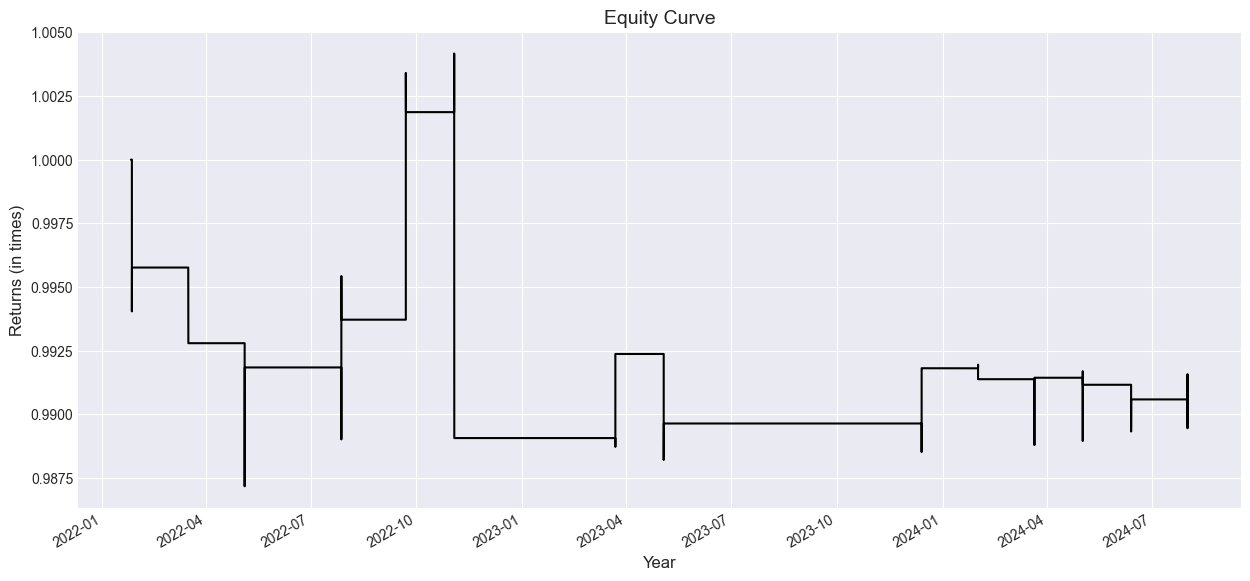

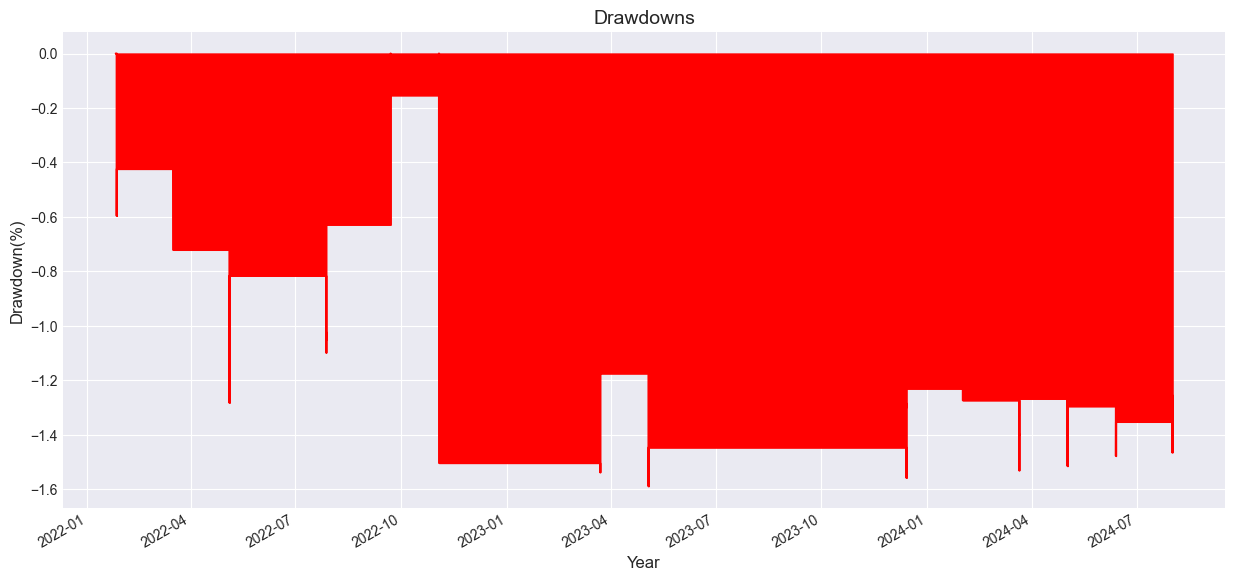

                 Strategy
Sharpe Ratio        -2.33
Maximum Drawdown   -1.59%


In [7]:
# Call the function
get_performance_metrics(minute_data.dropna())

The strategy using the rolling sentiment score along with the price trend generated a Sharpe ratio of -2.33 with a maximum drawdown of 1.59%. It can be observed that there is no improvement in the performance by using the rolling sentiment score along with the price trend. 
<a id='conclusion'></a>

## Conclusion and Next Steps
In this notebook, you tested the variation of a trading strategy based on the price trend and rolling sentiment score it didn't greatly improve the performance of the strategy. In the upcoming notebooks, we will explore the variations of this strategy by entering the positions post FOMC meeting releases holding the positions till the end of the day and studying how the performance changes. <br><br>